In [1]:
import os
import matplotlib.pyplot as plt
import sys
import torch
sys.path.append("./Utils")
from utils import get_padded_loaders, load_checkpoint
sys.path.append("./Models")
from ConvMixer import ConvMixer

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Model 

In [13]:
day_and_run = "2022_05_07_big10"
logs = f"./Checkpoints_convmixer/{day_and_run}/training_logs.pt"
weights = f"./Checkpoints_convmixer/{day_and_run}/my_check.pth.tar"
parameters = f"./Checkpoints_convmixer/{day_and_run}/training_params.pt"

In [14]:
logs = torch.load(logs)
params = torch.load(parameters)

In [15]:
params

{'LR': 0.002,
 'BATCH_SIZE': 2,
 'NUM_EPOCHS': 700,
 'LOSS_WEIGHTS': 5,
 'LOSS_FUNC': 'DICE+BCE_weights=5_ratio=0.8',
 'DEPTH': 20,
 'KERNEL': 3,
 'PATCH_SIZE': 3,
 'H': 375,
 'ROTATION': [-180, 180],
 'HFLIP_PROB': 0.5,
 'BRIGHTNESS': [0.5, 1.65],
 'CONTRAST': [0.5, 1.7],
 'GAMMA': [0.7, 1.8],
 'AFFINE_PROB': 0.15,
 'AFFINE_TRANSLATE': [0.2, 0.2],
 'AFFINE_SCALE': [1, 1.3],
 'AFFINE_SHEARS': [0.1, 0.1],
 'NOISE': (0, 0.1),
 'DICE': 0.8227198325488538,
 'ACCURACY': 0.9688886477623457,
 'AUC': 0.8936940687917801}

In [16]:
# Model Hyperparams
LR = params["LR"]
BATCH_SIZE = params["BATCH_SIZE"]
NUM_EPOCHS = params["NUM_EPOCHS"]
NUM_WORKERS = 0
PIN_MEMORY = True
LOAD_MODEL = False
LOSS_WEIGHTS = params["LOSS_WEIGHTS"]
CONTROL_METRIC = "dice"
RATIO = int(params["LOSS_FUNC"][-1]) # The higher the more weight to BCE
LOSS_METRIC = f"DICE+BCE_weights={LOSS_WEIGHTS}_ratio={RATIO}"
DEPTH = params["DEPTH"]
KERNEL = params["KERNEL"]
PATCH_SIZE = params["PATCH_SIZE"]
H = params["H"]
# LOSS_METRIC = "tversky"
# tversky = {"alpha":0.7, "beta":0.3, "smooth":1.33333}
# f"DICE+BCE_weights={LOSS_WEIGHTS}_ratio={RATIO}"

# Training Loader params

kwargs = {'train_dir': '../Data/dataset_DRIVE/training/images',
          'train_maskdir': '../Data/dataset_DRIVE/training/1st_manual',
          'val_dir': '../Data/dataset_DRIVE/validation/images',
          'val_maskdir': '../Data/dataset_DRIVE/validation/1st_manual',
          'batch_size': BATCH_SIZE,
          'rotation': params["ROTATION"],
          'hflip_prob': params["HFLIP_PROB"],
          'brightness': params["BRIGHTNESS"],
          'contrast': params["CONTRAST"],
          'gamma': params["GAMMA"],
          'affine_prob': params["AFFINE_PROB"],
          'affine_translate': params["AFFINE_TRANSLATE"],  # Horiz and vert translation
          'affine_scale': params["AFFINE_SCALE"],
          'affine_shears': params["AFFINE_SHEARS"],
          'noise': params["NOISE"],  # (Mean,std)
          'num_workers': 0,
          'pin_memory': True}

train_loader, val_loader = get_padded_loaders(**kwargs)

In [17]:
print(logs["best_auc"])
print(logs["best_accuracy"])
print(logs["best_dice"])

0.8936940687917801
0.9688886477623457
0.8227198325488538


In [8]:
checkpoints_x = []
checkpoints_y = []
k = 0
for i,j in zip(logs['val_dice'], logs['saved']):
    if j:
        checkpoints_x.append(k)
        checkpoints_y.append(i)
    k+=1

In [9]:
len(logs["loss"])

12000

In [10]:
import numpy as np
interval = int(16/BATCH_SIZE) #Train images / batch size
loss_avg = [np.mean(logs["loss"][i:i+interval]) for i in range(0,len(logs["loss"]), interval)]

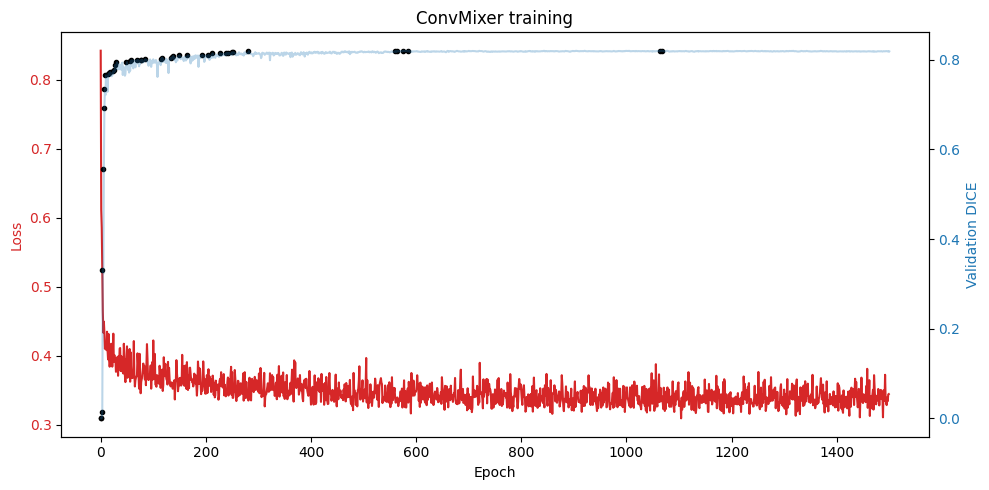

In [11]:
plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["figure.dpi"] = 100
fig, ax1 = plt.subplots()
ax1.set_title("ConvMixer training")

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_avg)), loss_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation DICE', color=color)  # we already handled the x-label with ax1
ax2.plot(range(1, NUM_EPOCHS+1, 1), logs['val_dice'], color=color, alpha=0.3)
ax2.scatter([i for i in checkpoints_x], checkpoints_y, color='k', marker=".")


ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Submission Grand Challenge

In [12]:
TEST_IMG_DIR = "../Data/dataset_DRIVE/test/images"

In [13]:
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms import ToTensor
from PIL import Image, ImageOps
from torch.utils.data import Dataset
import torchvision

In [14]:
class DRIVE_dataset_padding (Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def transform_test(self, image):
        # Padding
        image = TF.pad(image, (5, 0, 6, 0), padding_mode="constant", fill=0) #left, top, right and bottom
        # Cropping
        image = ImageOps.crop(image, (0, 4, 0, 4))
        # Transform to tensor
        tens = ToTensor()
        image = tens(image)
        return image

    def __getitem__(self, index):

        number = self.images[index][0:2]
        image = f'{number}_test.tif'

        img_path = os.path.join(self.image_dir, image)

        img = Image.open(img_path).convert("RGB")

        # Fuerzo a 3 canales aunque solo sea uno para poder
        # aplicarle las mismas transformaciones
        img = self.transform_test(img)

        # Devuelvo solo 1 canal del label
        return img, number

def get_padded_loaders(
    test_dir,
    batch_size,
    num_workers,
    pin_memory
):

    test_ds = DRIVE_dataset_padding(
        image_dir=test_dir
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return test_loader

In [15]:
# Model Hyperparams
BATCH_SIZE = 1
test_loader = get_padded_loaders(TEST_IMG_DIR, BATCH_SIZE, 0, True)

In [16]:
model = ConvMixer(h=H,depth=DEPTH, kernel_size=KERNEL, patch_size=PATCH_SIZE).to(DEVICE)
load_checkpoint(torch.load(weights, map_location=torch.device(DEVICE)),
    model)
model.eval()

The Net has 2 970 417 parameters
 => Loading checkpoint 


ConvMixer(
  (embedding_layer): Sequential(
    (0): Conv2d(3, 375, kernel_size=(3, 3), stride=(3, 3))
    (1): ActBnLayer(
      (bn_layer): BatchNorm2d(375, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (convmixer_layers): Sequential(
    (0): ConvMixerLayer(
      (depthwise_conv): Conv2d(375, 375, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=375)
      (actbn1): ActBnLayer(
        (bn_layer): BatchNorm2d(375, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (pointwise_conv): Conv2d(375, 375, kernel_size=(1, 1), stride=(1, 1))
      (actbn2): ActBnLayer(
        (bn_layer): BatchNorm2d(375, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ConvMixerLayer(
      (depthwise_conv): Conv2d(375, 375, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=375)
      (actbn1): ActBnLayer(
        (bn_layer): BatchNorm2d(375, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [17]:
model.eval()
if not os.path.exists(f"../Data/dataset_DRIVE/submit_convmixer/{day_and_run}"):
    os.makedirs(f"../Data/dataset_DRIVE/submit_convmixer/{day_and_run}")
for i in test_loader:
    image = i[0].to(device=DEVICE)
    with torch.no_grad():
        preds = model(image)
        preds = (preds > 0.5).float()
        preds = TF.pad(preds, (0, 4, 0, 4), padding_mode="constant", fill=0)
        preds = preds[:, :, :, 5:570]
    torchvision.utils.save_image(
            preds, f"../Data/dataset_DRIVE/submit_convmixer/{day_and_run}/{i[1][0]}"+".png")


# Generate images for convmixer

In [37]:
BATCH_SIZE = 20
test_loader = get_padded_loaders(TEST_IMG_DIR, BATCH_SIZE, 0, True)
problematic = next(iter(test_loader))[0][8]

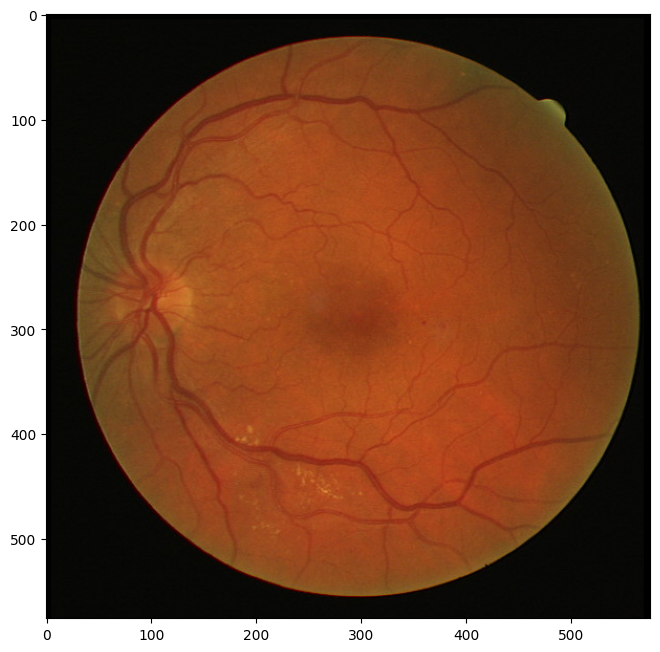

In [38]:
plt.imshow(problematic.squeeze(0).permute(1, 2, 0))

In [39]:
problematic = problematic.unsqueeze(0)
x = problematic.to(device=DEVICE)
with torch.no_grad():
    preds = model(x)
    preds = (preds > 0.5).float()

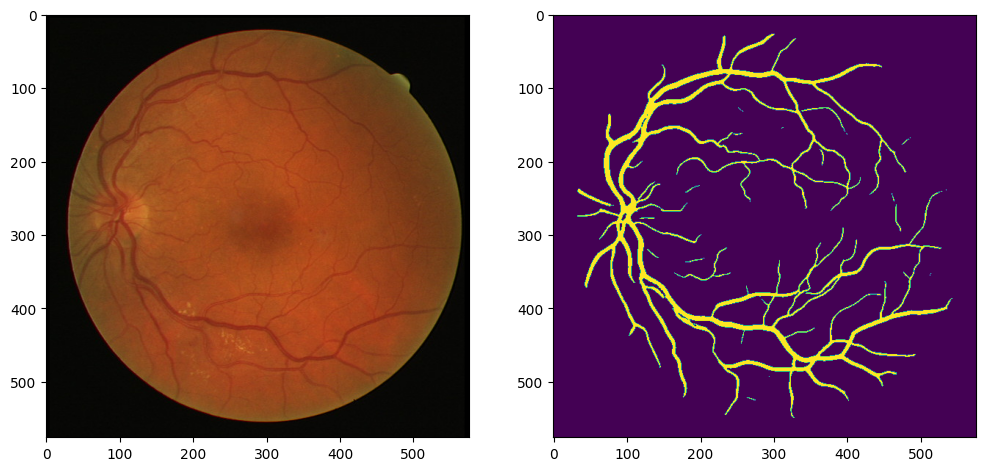

In [40]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.dpi"] = 100

fig, ax = plt.subplots(1,2)
ax[0].imshow(problematic.squeeze(0).permute(1, 2, 0))
#ax[0].set_title("Original image")
ax[1].imshow(preds.squeeze(0).squeeze(0))
#ax[1].set_title("ConvMixer predictions")